In [ ]:
import requests
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from numpy import asarray

In [ ]:
#custom_vision_imgurl = 'https://<resource_name>.cognitiveservices.azure.com/customvision/v3.0/Prediction/<project_id>/detect/iterations/<published_name>/image'
#api_key = '<YOUR_PREDICTION_KEY>'

In [ ]:
data = open('1.jpg', 'rb').read()
img = cv2.imdecode(np.array(bytearray(data), dtype='uint8'), cv2.IMREAD_COLOR)

# it's for one picture

### tag-id、boundingbox

In [ ]:
custom_vision_headers = {
    'Content-Type': 'application/octet-stream',
    'Prediction-Key': api_key
    }

custom_vision_resp = requests.post(url = custom_vision_imgurl,
    data = data,
    headers = custom_vision_headers).json()

In [ ]:
hit = pd.DataFrame(custom_vision_resp['predictions']).sort_values(by='probability',ascending=False).head(1).to_dict()

print(hit)

{'probability': {0: 0.99996173}, 'tagId': {0: '1763aca3-c67d-4ab8-8eac-c94986b8887c'}, 'tagName': {0: 'license'}, 'boundingBox': {0: {'left': 0.45326746, 'top': 0.4549838, 'width': 0.17613167, 'height': 0.108475775}}}


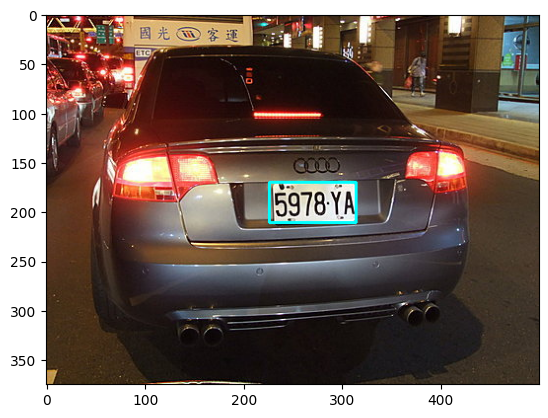

In [ ]:
# extract the bounding box for the detected number plate
boundingbox = list(hit['boundingBox'].values())[0]
l, t, w, h = (boundingbox['left'],
    boundingbox['top'],
    boundingbox['width'],
    boundingbox['height'])

# extract bounding box coordinates and dimensions are scaled using image dimensions
polylines1 = np.multiply([[l,t],[l+w,t],[l+w,t+h],[l,t+h]],
    [img.shape[1],img.shape[0]])

# draw polylines based on bounding box results
temp_img = cv2.polylines(img, np.int32([polylines1]),
    isClosed = True, color = (255, 255, 0), thickness = 2)

# display the original image with the plate region
plt.imshow(cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB))

### choose the license place

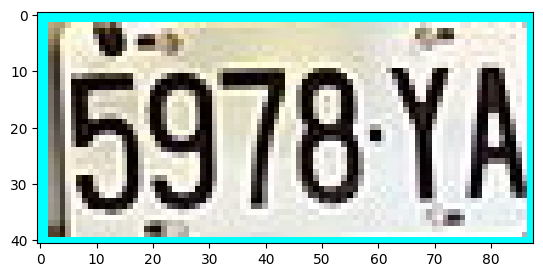

In [ ]:
# crop the image to the bounding box of the plate region
crop_x = polylines1[:,0].astype('uint16')
crop_y = polylines1[:,1].astype('uint16')

img_crop = img[np.min(crop_y):np.max(crop_y),
    np.min(crop_x):np.max(crop_x)]

# display the detected plate region
plt.imshow(cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB))

## OCR take the text
### 在調用Azure Computer Vision API之前,我們必須確保發送的圖像具有至少50像素的高度

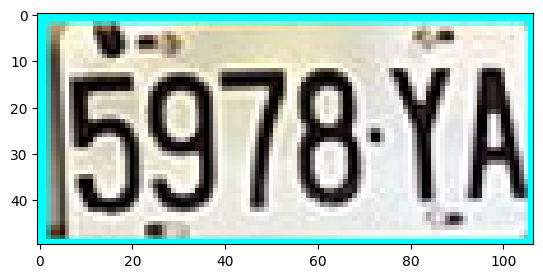

In [ ]:
img_crop_height = img_crop.shape[0]
if img_crop_height < 50:
      pil_image = Image.fromarray(img_crop)
      img_crop_width = img_crop.shape[1]
      difference = 50 / img_crop_height
      resized_dimensions = (int(img_crop_width * difference), int(img_crop_height * difference))
      pil_image_resized = pil_image.resize(resized_dimensions)
      img_crop_resized = asarray(pil_image_resized)

      plt.imshow(cv2.cvtColor(img_crop_resized, cv2.COLOR_BGR2RGB))

### OCR tag-id、boundingbox

In [ ]:
#computer_vision_imgurl = <endpoint>/computervision/imageanalysis:analyze?features=caption,read&model-version=latest&language=en&api-version=2024-02-01

建立這個：https://portal.azure.com/#create/Microsoft.CognitiveServicesComputerVision

抓 api，結論，免費版用不了

In [ ]:
crop_bytes = bytes(cv2.imencode('.png', img_crop_resized)[1])

# make a call to the computer_vision_imgurl
computer_vision_resp = requests.post(
    url=computer_vision_imgurl,
    data=crop_bytes,
    headers={
        'Ocp-Apim-Subscription-Key': api_key,
        'Content-Type': 'application/octet-stream'}).json()

In [ ]:
computer_vision_resp

{'error': {'code': '401',
  'message': 'Access denied due to invalid subscription key or wrong API endpoint. Make sure to provide a valid key for an active subscription and use a correct regional API endpoint for your resource.'}}

In [ ]:
print('The plate number is {}'.format(computer_vision_resp['readResult']['content']))

KeyError: 'readResult'

### 同效果但不知道能不能行

In [ ]:
!pip install tesseract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 26.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tesseract: filename=tesseract-0.1.3-py3-none-any.whl size=45562552 sha256=1e9b67fe84ed869eb0658592747424471c786b7987fd644b7cc5ba181e199493
  Stored in directory: /root/.cache/pip/wheels/71/c9/aa/698c579693e83fdda9ad6d6f0d8f61ed986e27925ef576f109
Successfully built tesseract


In [ ]:
import tesseract
text = tesseract.image_to_string(img_crop_resized, config="--psm 8")
text = text.replace(" ", "")

ModuleNotFoundError: No module named 'pytesseract'

In [ ]:
print('text')